<a href="https://colab.research.google.com/github/santiagogr10/neural-networks-exercises/blob/main/Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Santiago García Rincón

Red Neuronal Convolucional
-----------------------------------------------------------------------------

Construcción de una Red Neuronal Convolucional para Clasificación de Imágenes en TensorFlow

Crear y entrenar una red neuronal convolucional para clasificar imágenes de un conjunto de datos de TensorFlow.

Entrega:

El trabajo debe ser entregado en formato de Jupyter Notebook (.ipynb).
El notebook debe contener explicaciones claras y comentarios adecuados en el código.
Incluye visualizaciones que ayuden a comprender el proceso de clasificación y el rendimiento del modelo.

##  Data set  **Flowers Dataset**

El **Flowers Dataset** es un conjunto de datos diseñado para tareas de clasificación de imágenes, que contiene imágenes de flores organizadas en diferentes categorías como margaritas, dientes de león, rosas, girasoles y tulipanes


In [45]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

train_size = 0.8
train_dataset = dataset['train'].take(int(info.splits['train'].num_examples * train_size))
val_dataset = dataset['train'].skip(int(info.splits['train'].num_examples * train_size))

class_names = info.features['label'].names
num_classes = len(class_names)


Podemos obtener información del data set

In [46]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

Vamos a visualizar algunas imágenes con sus respectivas etiquetas

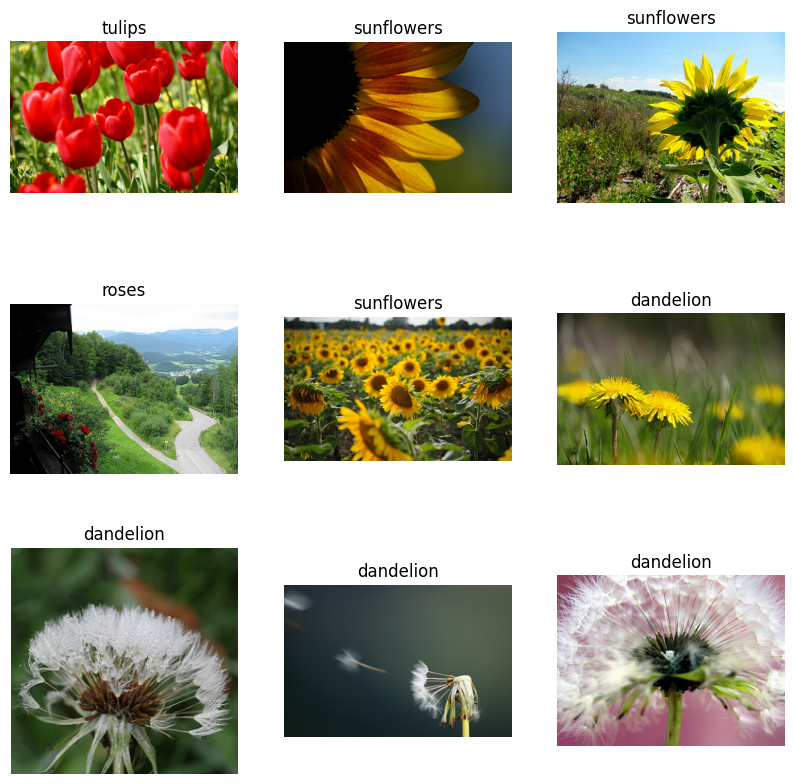

In [47]:
import matplotlib.pyplot as plt

class_names = info.features['label'].names

def visualize_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))

    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())
        plt.title(class_names[label.numpy()])
        plt.axis("off")

    plt.show()

visualize_data(train_dataset, class_names)


En el codigo de abajo estamos **preprocesando las imágenes** del dataset para adaptarlas al modelo de aprendizaje automático. Primero, cambiamos el tamaño de las imágenes a **128x128 píxeles** (`tf.image.resize`) para que todas tengan las mismas dimensiones. Luego, normalizamos los valores de los píxeles dividiéndolos entre 255 . Después de eso, organizamos las imágenes en **lotes de 32** (`batch`) y mezclamos aleatoriamente los datos de entrenamiento (`shuffle`) para evitar patrones que afecten el aprendizaje. Finalmente, aplicamos el mismo preprocesamiento a los datos de validación, pero sin mezclar.

In [48]:
IMG_SIZE = 128
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label


train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
val_dataset = val_dataset.map(preprocess).batch(BATCH_SIZE)


Aquí estamos cargando el modelo preentrenado **MobileNetV2**, que ya fue entrenado con el conjunto de datos **ImageNet** para reconocer características generales en imágenes. Usamos este modelo como base (`base_model`) y especificamos que no incluya su capa de clasificación final (`include_top=False`), ya que lo adaptaremos a nuestro problema. Finalmente, lo **congelamos** (`trainable=False`) para que sus pesos no se actualicen durante las primeras etapas de entrenamiento, aprovechando directamente las características generales que ya aprendió.

In [49]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False


Aquí estamos construyendo el modelo final. Partimos de la base preentrenada (`base_model`) y añadimos nuevas capas personalizadas para adaptarlo a la clasificación de flores. Usamos una capa de **GlobalAveragePooling2D** para reducir las características extraídas a un vector compacto, luego una capa **Dense** con 128 neuronas y activación ReLU para aprender patrones específicos del dataset, y una capa **Dropout** . Finalmente, añadimos una capa **Dense** con activación **softmax** para clasificar las imágenes en las categorías correspondientes al número de clases (`num_classes`).

In [50]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model, l
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])



In [51]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


El entrenamiento, dado lo pesado, lo entrene con pocas **ephocs**

In [52]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 675ms/step - accuracy: 0.5810 - loss: 1.1153 - val_accuracy: 0.8556 - val_loss: 0.4035
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 557ms/step - accuracy: 0.8421 - loss: 0.4462 - val_accuracy: 0.8733 - val_loss: 0.3482
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 513ms/step - accuracy: 0.8876 - loss: 0.3288 - val_accuracy: 0.8747 - val_loss: 0.3322
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 697ms/step - accuracy: 0.9050 - loss: 0.2726 - val_accuracy: 0.8733 - val_loss: 0.3469
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 518ms/step - accuracy: 0.9207 - loss: 0.2072 - val_accuracy: 0.8815 - val_loss: 0.3237


Aqui evauamos como nos va con nuevos datos

In [63]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print( val_accuracy ,val_loss )


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 568ms/step - accuracy: 0.8636 - loss: 0.3604
0.8814713954925537 0.32374632358551025


Visualizando las predicciones del modelo en un lote del conjunto de datos de validación.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


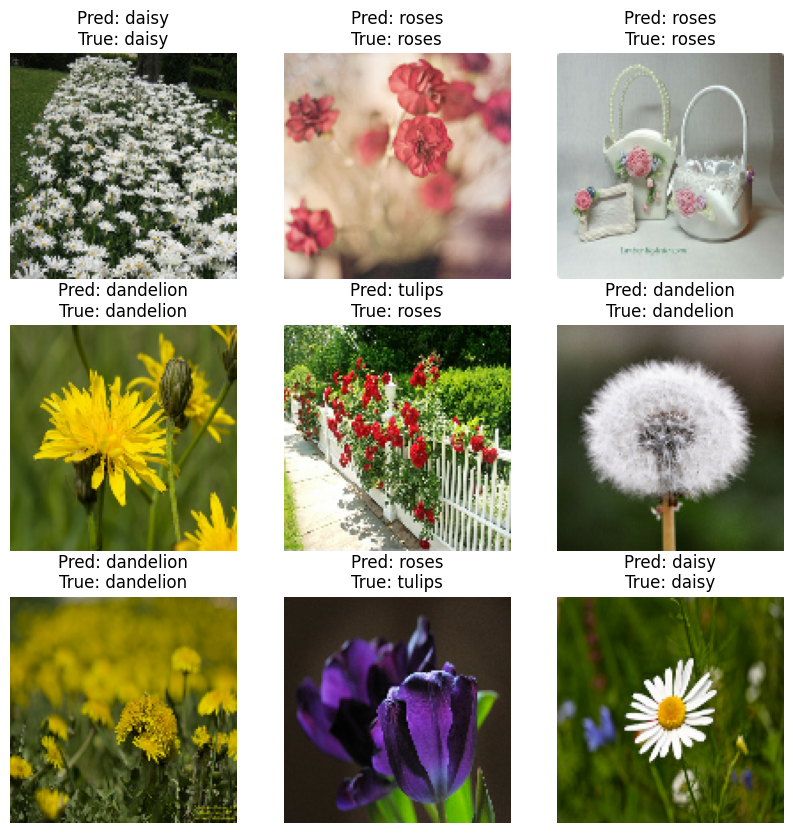

In [55]:
for images, labels in val_dataset.take(1):
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Pred: {class_names[predicted_classes[i].numpy()]}\nTrue: {class_names[labels[i].numpy()]}")
        plt.axis("off")
    plt.show()


 Recopilando las etiquetas verdaderas y las predicciones del modelo para todo el conjunto de validación

In [57]:
true_labels = []
predicted_labels = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluar otras metricas del modelo

In [61]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels, target_names=class_names))


              precision    recall  f1-score   support

   dandelion       0.93      0.88      0.91       158
       daisy       0.86      0.90      0.88       141
      tulips       0.85      0.87      0.86       146
  sunflowers       0.87      0.89      0.88       151
       roses       0.89      0.87      0.88       138

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



Matriz de confusion

<Figure size 1000x1000 with 0 Axes>

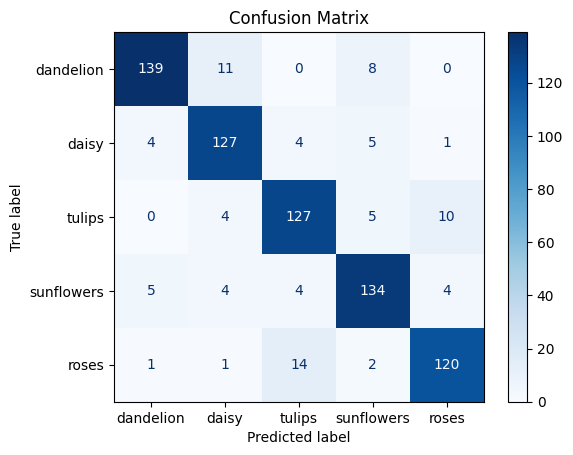

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.show()
